In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel

import os
import pickle
from time import time
from sklearn.decomposition import PCA

In [3]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])
    
# training set - read in filenames and logspace flux values
with open ('../grid_metadata/core78.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cube78.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cube78.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)   

In [4]:
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-42]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)
eigenseds.shape

done in 0.023s


(40, 500)

In [5]:
# slices - read in filenames and logspace flux values
with open ('../grid_metadata/slicenames.txt', 'rb') as fp:
    slicenames = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    slicevals = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    nanslicevals = pickle.load(fp)

# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

In [6]:
fitdata=[]

for i in range(len(param_names)):
    fitdata.append([])
for i in range(len(param_names)):
    for j in range(11):
        modeldata=[]
        paramval=steps[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        fitdata[i].append(modeldata)

In [7]:
paramvals=[]
weights=[]
for param in range(15):
    pl=[]
    wl=[]
    for model in range(11):
        pl.append(fitdata[param][model][0])
    paramvals.append(pl)
    
    for w in range(10):
        wsl=[]
        for model in range(11):
            wsl.append(fitdata[param][model][w+1])
        wl.append(wsl)
    weights.append(wl)

In [8]:
np.array(weights).shape

(15, 10, 11)

In [9]:
def load_pcwpar(param,weight):
    return np.array(paramvals[param]).reshape(-1,1), np.array(weights[param][weight])

In [10]:
X, y = load_pcwpar(0,0)

In [14]:
kernel =  RBF(length_scale=900,length_scale_bounds=(100,2500))

In [15]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True)

In [16]:
gp.fit(X,y)

GaussianProcessRegressor(alpha=0, copy_X_train=True,
             kernel=RBF(length_scale=900), n_restarts_optimizer=0,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [17]:
print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))


Learned kernel: RBF(length_scale=253)
Log-marginal-likelihood: -161.662


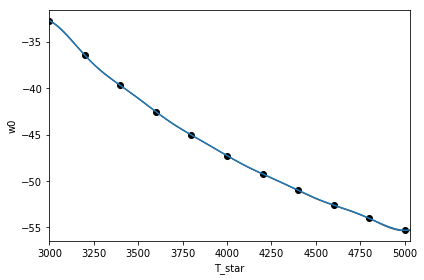

In [18]:
X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel(param_names[0])
plt.ylabel("w"+str(0))
plt.tight_layout()
plt.show()

In [19]:
X_

array([[3000.        ],
       [3002.03203203],
       [3004.06406406],
       [3006.0960961 ],
       [3008.12812813],
       [3010.16016016],
       [3012.19219219],
       [3014.22422422],
       [3016.25625626],
       [3018.28828829],
       [3020.32032032],
       [3022.35235235],
       [3024.38438438],
       [3026.41641642],
       [3028.44844845],
       [3030.48048048],
       [3032.51251251],
       [3034.54454454],
       [3036.57657658],
       [3038.60860861],
       [3040.64064064],
       [3042.67267267],
       [3044.7047047 ],
       [3046.73673674],
       [3048.76876877],
       [3050.8008008 ],
       [3052.83283283],
       [3054.86486486],
       [3056.8968969 ],
       [3058.92892893],
       [3060.96096096],
       [3062.99299299],
       [3065.02502503],
       [3067.05705706],
       [3069.08908909],
       [3071.12112112],
       [3073.15315315],
       [3075.18518519],
       [3077.21721722],
       [3079.24924925],
       [3081.28128128],
       [3083.313

In [141]:
x=np.linspace(3000,5000,50).reshape(-1,1)
y_pred,sigma=gp.predict(x,return_std=True)

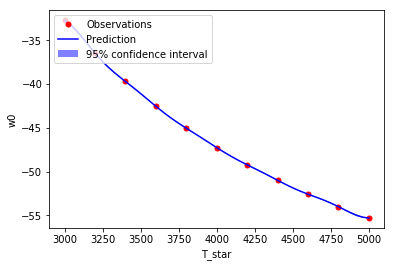

In [145]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel(param_names[0])
plt.ylabel('w'+str(0))
plt.legend(loc='upper left')


In [153]:
load_pcwpar(0,7)

(array([[3000.],
        [3200.],
        [3400.],
        [3600.],
        [3800.],
        [4000.],
        [4200.],
        [4400.],
        [4600.],
        [4800.],
        [5000.]]),
 array([-0.09469894,  0.26905367,  0.5968873 ,  0.8888934 ,  1.1562479 ,
         1.4139272 ,  1.6487229 ,  1.8630666 ,  2.059304  ,  2.2461848 ,
         2.4257839 ], dtype=float32))


Learned kernel: RBF(length_scale=253)
Log-marginal-likelihood: -161.662


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


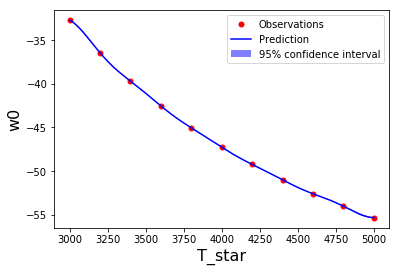


Learned kernel: RBF(length_scale=267)
Log-marginal-likelihood: -111.996


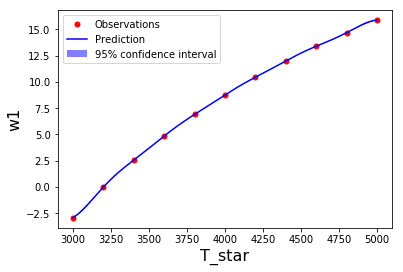


Learned kernel: RBF(length_scale=399)
Log-marginal-likelihood: -0.103


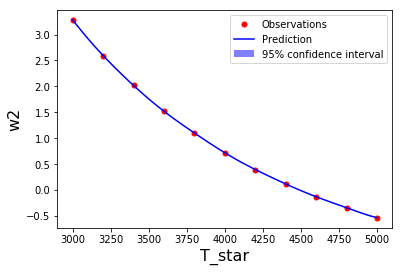


Learned kernel: RBF(length_scale=407)
Log-marginal-likelihood: 6.596


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


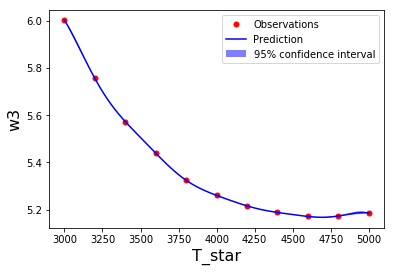


Learned kernel: RBF(length_scale=464)
Log-marginal-likelihood: 7.528


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


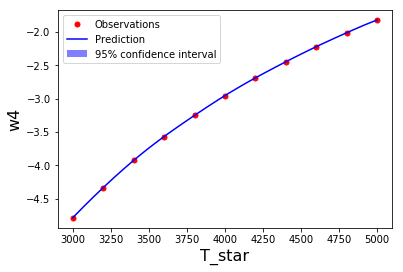


Learned kernel: RBF(length_scale=451)
Log-marginal-likelihood: 8.868


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


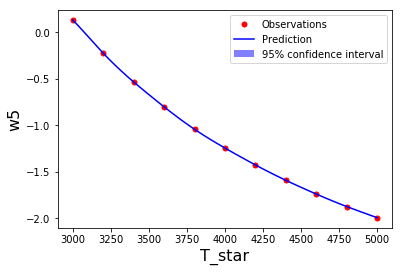


Learned kernel: RBF(length_scale=419)
Log-marginal-likelihood: 4.115


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


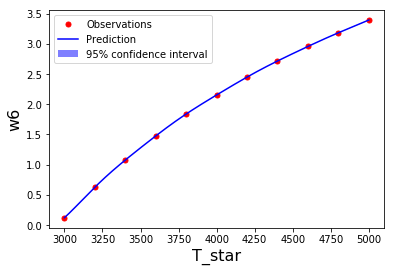


Learned kernel: RBF(length_scale=451)
Log-marginal-likelihood: 7.693


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


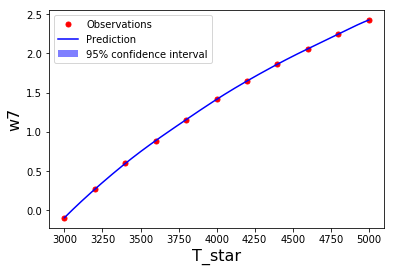


Learned kernel: RBF(length_scale=521)
Log-marginal-likelihood: 15.090


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00065239]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


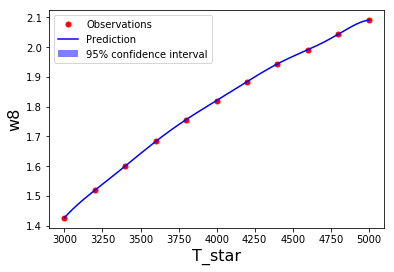

/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "



Learned kernel: RBF(length_scale=498)
Log-marginal-likelihood: 9.046


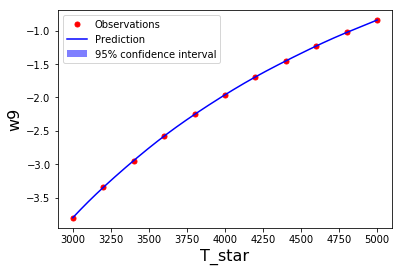

In [162]:
par=0
kernel =  RBF(length_scale=500,length_scale_bounds=(100,2000))

for w in range(10):
    X, y = load_pcwpar(par,w)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True)
    gp.fit(X,y)
    print("\nLearned kernel: %s" % gp.kernel_)
    print("Log-marginal-likelihood: %.3f"
          % gp.log_marginal_likelihood(gp.kernel_.theta)) 
    X_ = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
    y_pred, y_std = gp.predict(X_, return_std=True)
 
    # Plot the function, the prediction and the 95% confidence interval based on the MSE
    plt.figure()
    plt.plot(X, y, 'r.', markersize=10, label='Observations')
    plt.plot(X_, y_pred, 'b-', label='Prediction')
    plt.fill(np.concatenate([X_, X_[::-1]]),
             np.concatenate([y_pred - 1.9600 * y_std,
                            (y_pred + 1.9600 * y_std)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel(param_names[par],fontsize=16)
    plt.ylabel('w'+str(w),fontsize=16)
    plt.legend()
    plt.show()


Learned kernel: RBF(length_scale=0.667)
Log-marginal-likelihood: -689402.110


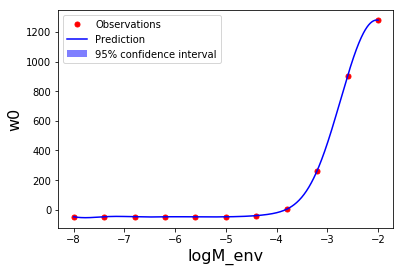


Learned kernel: RBF(length_scale=0.1)
Log-marginal-likelihood: -13887.642


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


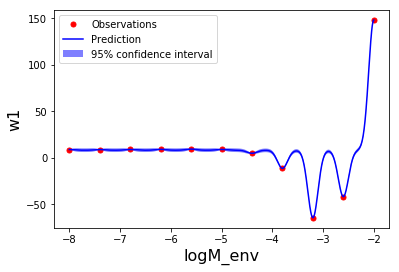


Learned kernel: RBF(length_scale=0.352)
Log-marginal-likelihood: -723.185


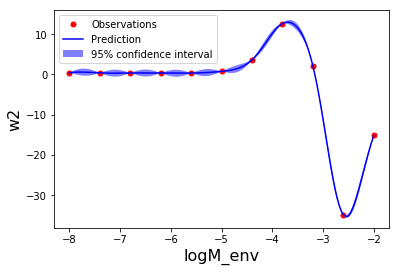


Learned kernel: RBF(length_scale=0.495)
Log-marginal-likelihood: -497.397


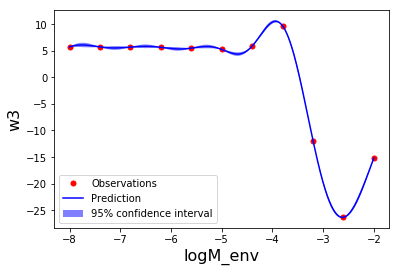


Learned kernel: RBF(length_scale=0.1)
Log-marginal-likelihood: -632.485


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


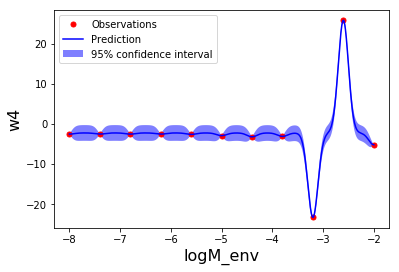


Learned kernel: RBF(length_scale=0.1)
Log-marginal-likelihood: -129.725


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


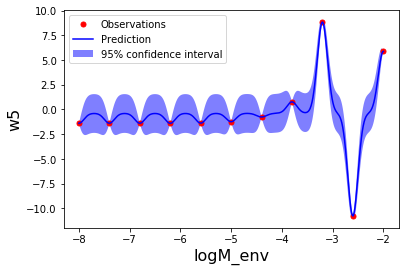


Learned kernel: RBF(length_scale=0.1)
Log-marginal-likelihood: -269.357


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


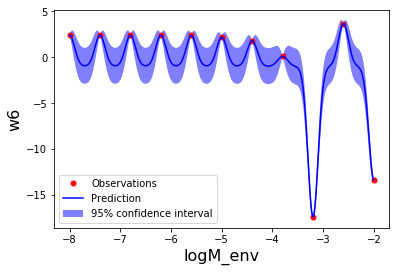


Learned kernel: RBF(length_scale=0.3)
Log-marginal-likelihood: -142.514

/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


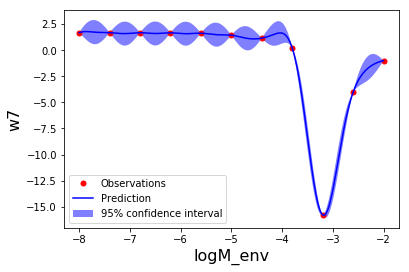


Learned kernel: RBF(length_scale=0.1)
Log-marginal-likelihood: -38.018


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


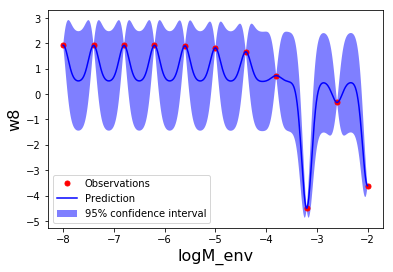


Learned kernel: RBF(length_scale=0.1)
Log-marginal-likelihood: -88.521


/users/eteng/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


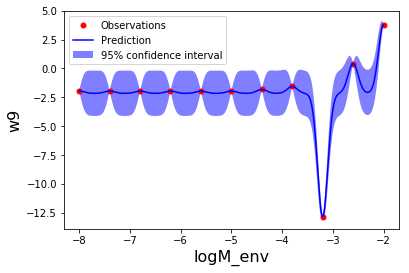

In [165]:
par=8
kernel =  RBF(length_scale=1,length_scale_bounds=(.1,4))

for w in range(10):
    X, y = load_pcwpar(par,w)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True)
    gp.fit(X,y)
    print("\nLearned kernel: %s" % gp.kernel_)
    print("Log-marginal-likelihood: %.3f"
          % gp.log_marginal_likelihood(gp.kernel_.theta)) 
    X_ = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
    y_pred, y_std = gp.predict(X_, return_std=True)
 
    # Plot the function, the prediction and the 95% confidence interval based on the MSE
    plt.figure()
    plt.plot(X, y, 'r.', markersize=10, label='Observations')
    plt.plot(X_, y_pred, 'b-', label='Prediction')
    plt.fill(np.concatenate([X_, X_[::-1]]),
             np.concatenate([y_pred - 1.9600 * y_std,
                            (y_pred + 1.9600 * y_std)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel(param_names[par],fontsize=16)
    plt.ylabel('w'+str(w),fontsize=16)
    plt.legend()
    plt.show()